### Investigate how good is the frequency baseline 

In [1]:
import pickle 
import sys 
sys.path.append("../backend/")
from wordfreq import word_frequency
import process_wordlist

In [2]:
wl = process_wordlist.Wordlist(curr_dir="../backend/") 
wl.estimate('abyss')

Finished loading the dictionary.


'C2'

In [3]:
### divide the data into 80-20 splits
from sklearn.model_selection import train_test_split
import numpy as np 

with open('../backend/english_profile_wordlist.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [4]:
total = 0
for level in data: 
    total += len(data[level][0])
total

6605

In [5]:
# data is a dictionary with key being the level 
from collections import deque 
import math 

X = deque()  
y = deque() 
level_map = {"A1": 1, "A2": 2, "B1": 3, "B2": 4, 
            "C1": 5, "C2": 6}

for level in data:
    level_data = data[level][0]
    print("level {} has {} data points".format(level, len(level_data)))
    level_truth = [level_map[level]]*len(level_data)
    X.extend([x for x in level_data])
    y.extend([truth for truth in level_truth])

level A1 has 591 data points
level A2 has 880 data points
level B1 has 1399 data points
level B2 has 1704 data points
level C1 has 1012 data points
level C2 has 1019 data points


In [6]:
X = list(X)
y = list(y)
len(X), len(y), len(set(y)) == 6

(6605, 6605, True)

In [7]:
X_train_word, X_test_word, y_train_word, y_test_word = train_test_split(np.array(X), np.array(y), 
                                                    test_size=0.2, random_state=42)

In [8]:
X = [math.log(word_frequency(x, 'en')+1e-7) for x in X]
len(X)

6605

In [9]:
X_test_word[X_test_word=='']

array([], dtype='<U18')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), 
                                                    test_size=0.2, random_state=42)

In [11]:
X_train.shape, X_test.shape, y_train.shape

((5284,), (1321,), (5284,))

In [12]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

X_train = X_train.reshape(-1, 1)
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
X_test = X_test.reshape(-1, 1)
y_pred = reg.predict(X_test)

In [14]:
filename = 'baseline_model.sav'
pickle.dump(reg, open('../backend/'+filename, 'wb'))

In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

1.51240316552658

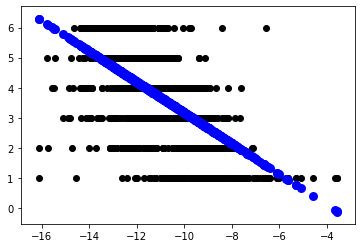

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.scatter(X_test, y_test, color="black")
plt.scatter(X_test, y_pred, color="blue", linewidth=3)
plt.show()

In [17]:
# check the wrong case of C2
import pandas as pd 
pd.concat([pd.DataFrame(X_test_word[(y_test!=y_pred) & (y_test==6)], columns=['x_test']), 
          pd.DataFrame(y_pred[(y_test!=y_pred) & (y_test==6)], columns=['y_pred']),
          pd.DataFrame(X_test[(y_test!=y_pred) & (y_test==6)], columns=['word_freq'])], axis=1).\
sort_values('word_freq', ascending=False).head(20)

,x_test,y_pred,word_freq
108,would-be,1.399990,-6.543043
103,saying,2.352079,-8.403418
105,off-putting,3.016332,-9.701363
62,assembly,3.059041,-9.784816
77,reform,3.187527,-10.035877
168,fundamental,3.400318,-10.451669
27,proceedings,3.528428,-10.701995
3,transmission,3.563737,-10.770988
118,parallel,3.563737,-10.770988
81,classification,3.623102,-10.886987


In [18]:
results = pd.concat([pd.DataFrame(X_test_word, columns=['word']),
                    pd.DataFrame(y_pred, columns=['y_pred']),
                    pd.DataFrame(y_test, columns=['y_test'])], axis=1)

In [19]:
def roundNearInt(x):
    if x <= 1:
        return 1 
    if x >= 6:
        return 6
    return round(x)

In [20]:
results['y_pred_class'] = results['y_pred'].apply(lambda x: roundNearInt(x))
results[results['y_pred_class']==results['y_test']]

,word,y_pred,y_test,y_pred_class
2,him,1.468322,1,1
3,soya,5.342304,5,5
4,bracket,4.182340,4,4
18,traditionally,3.833352,4,4
22,mind,2.247144,2,2
...,...,...,...,...
1307,trend,3.364420,3,3
1309,terrifying,4.101704,4,4
1310,gay,2.941039,3,3
1311,inspiration,3.551695,4,4


In [21]:
448/1321

0.33913701741105223

In [22]:
results

,word,y_pred,y_test,y_pred_class
0,accountant,4.333118,3,4
1,influential,3.821118,5,4
2,him,1.468322,1,1
3,soya,5.342304,5,5
4,bracket,4.182340,4,4
...,...,...,...,...
1316,sell,2.882447,2,3
1317,run,2.211228,1,2
1318,shyness,5.147553,5,5
1319,bear,3.082286,2,3


In [23]:
results[(results['y_pred_class']-results['y_test'])==1|
        (results['y_pred_class']-results['y_test']==-1)].sample(30)

,word,y_pred,y_test,y_pred_class
788,work,1.645646,1,2
488,misinform,6.128776,5,6
688,long,1.810182,1,2
1132,tiger,3.576070,3,4
277,musician,3.973476,3,4
101,dot,3.913620,3,4
96,convince,3.657044,3,4
52,nightmare,3.786078,3,4
301,walking,2.952720,2,3
1104,perhaps,2.671307,2,3


In [24]:
## within one class accuracy 
(448+275)/1321

0.5473126419379258

In [25]:
word_frequency('i-am-not', 'en')

0.000518